# Look at changes in clapping rates by location

This notebook visualises the median clapping rate for members of an audience. Hypothesis: people who are near each other converge in clapping rate faster than those who are not. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import pingouin as pg
from scipy.spatial.distance import pdist, squareform
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import imageio


In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
%reload_ext autoreload

In [4]:
# Now to map those values to locations, need to import some details.
# these are old ID codes, need to replace. 
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

internal_mlmotion = general_loc + 'Internal/Motion_ML/'
internal_ax3 = general_loc +  'Internal/Motion_AX3/'
internal_Part = general_loc + 'Internal/Participants/'
internal_time = general_loc + 'Internal/Timing/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [5]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
partDets = partDets.loc[~partDets['X'].isna(),:]
MovingParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements

Part_Codes = list(MovingParts.Participant_Code.values)


In [6]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
565,AEQ082,AEQ083,3.0,0,Stranger
566,AEQ082,AEQ087,3.0,0,Stranger
567,AEQ083,AEQ089,3.0,1,Family_ParentChild
568,AEQ084,AER090,3.0,1,Family_ParentChild


## Load a clapping section
individual claps 

In [7]:
claps_folder = 'C:/Users/finnu/dev/copenhagen-musiclab-clapping/clapfiles/clapping_peaks/'
Clap_files = os.listdir(claps_folder)
clapname = Clap_files[2]
# 6 finale, 14 schnittke, 1 beethoven, 0 bach
clapname

'clapping_after_introduction_peaks.csv'

In [8]:
Clap_files

['bach_applause_peaks.csv',
 'beethoven_applause_peaks.csv',
 'clapping_after_introduction_peaks.csv',
 'clapping_between_speeches_1_peaks.csv',
 'clapping_between_speeches_2_peaks.csv',
 'concert_begins_peaks.csv',
 'final_applause_peaks.csv',
 'folk_music_1_applause_peaks.csv',
 'folk_music_2_applause_peaks.csv',
 'folk_music_3_applause_peaks.csv',
 'folk_music_4_applause_peaks.csv',
 'folk_music_5_applause_peaks.csv',
 'musicians_return_1_peaks.csv',
 'musicians_return_2_peaks.csv',
 'schnittke_applause_peaks.csv',
 'Schnittke_Stage_events.csv']

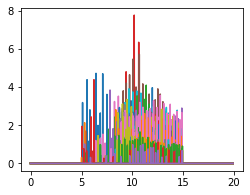

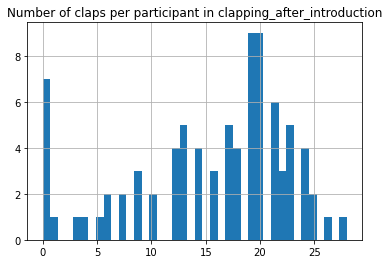

[85, 0.25882352941176473]


In [177]:
# read file
peaks = pd.read_csv(claps_folder + clapname,index_col=0)
exp_name = clapname[:-10]
peaks = peaks.fillna(0)
ts = pd.Series(np.arange(0,len(peaks))*0.02)
t_end = ts.iloc[-1]

df_claps = pd.DataFrame(index = ts,data = peaks.values,columns = peaks.columns)
df_claps.plot(figsize = [2+t_end/10,3],legend = False)
plt.show()
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant in ' + exp_name)
plt.show()

a = df_OnlyClaps.sum().index
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>20]]
print([len(a),len(a[df_OnlyClaps.sum()>20])/len(a)])
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>20]]
#df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)
# Evaluate length or recording 

In [159]:
# note these time are approximate to around the second, aligned roughly to final clapping excerpt times 
# Should be confirmed with better video interface than youtube
musician_times = pd.read_csv('./Data/Final_clapping_section_accelerometer/Final_Stage_events.csv',sep=",") #SV alignment for beeps
#musician_times

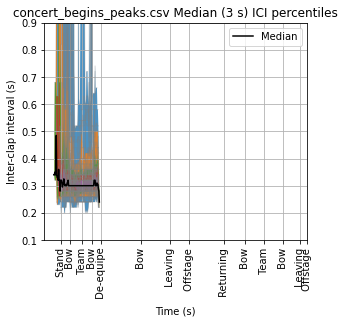

In [167]:
if t_end>15:
    # evaluate clapp statistics
    t_interval = 1.5
    sampletimes = np.arange(0+t_interval,t_end-t_interval,0.2)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

    for samp in range(len(sampletimes)):
        t_0 = sampletimes[samp]
        sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
        clap_stats = []
        cols = sub_claps.columns
        these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
        for partn in cols:
            ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
            if ici.notna().sum()>0:
                these_claps[partn]=np.nanmedian(ici)
        Clap_Feats.loc[t_0] = these_claps
    # plot statistics
    df_A = Clap_Feats.copy()
    df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','Midrange','NotNa_C','NotNa_p'])
    df_spans = pd.DataFrame(index = df_A.index,columns = ['Upper','Lower'])
    t_interval = 3
    cntiles = np.array([0,0.1,0.2,0.3,0.4])
    for i, row in df_A.iterrows():
        sub_row = row[row.notna()]
        if len(sub_row)>0:
            these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                           'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
            df_feats.loc[i,:] = these_stats
    df_feats = df_feats.dropna()

    fig,ax = plt.subplots(1,1,figsize=[2+t_end/10,4])
    df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
    #ax.line(df_A.index,df_A)
    df_feats.plot(y='Median',color="black", ax=ax)

    for pc in cntiles:
        for i, row in df_A.iterrows():
            sub_row = row[row.notna()]
            if len(sub_row)>0:
                these_stats = {'Lower':sub_row.quantile(q=pc,interpolation='nearest'),'Upper':sub_row.quantile(q=1-pc,interpolation='nearest')}
                df_spans.loc[i,:] = these_stats
        df_spans = df_spans.dropna()

        x = np.array(df_spans.index)
        y1 = np.array(df_spans.Lower,dtype=np.float32)
        y2 = np.array(df_spans.Upper,dtype=np.float32)
        ax.fill_between(x,y1,y2,alpha = 0.8)

    plt.ylim([0.1,0.9])
    plt.xlim([0,t_end])
    plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')

    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Inter-clap interval (s)')
    plt.title(clapname +' Median (3 s) ICI percentiles')
    plt.savefig(clapname+'_Applause_Local_ICI_medians_CentileTS_ME.png',dpi=400)
    plt.show()

In [168]:
ClapDets=partDets.loc[partDets['Participant_Code'].isin(Clap_Feats.columns),:]
#Clap_Feats = Clap_Feats[ClapDets['Participant_Code']]
Clap_Feats.fillna(0,inplace = True)
Clap_Feats

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,ADR070,AEQ077,AEQ079,AEQ080,AEQ081,AEQ082,AEQ084,AEQ087,AEQ088,AER090
1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


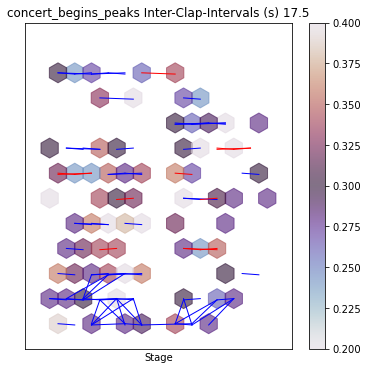

In [169]:
i = 80
plt.figure(figsize=[6,6])
plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values, cmap='twilight', vmin=0.2, vmax=0.4, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,13])
plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[i,:].name,2)))
cbar = plt.colorbar()

# now add the relationships Friends
Friends = Near_Rels[Near_Rels['Relationship'].str.contains('Friend')]
Friends
for i,ship in Friends.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:] 
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.05,P2['X']]),'b',linewidth = 1)

Family = Near_Rels[Near_Rels['Relationship'].str.contains('Family')]
Family
for i,ship in Family.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:]
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.05,P2['X']]),'r',linewidth = 1)


# cbar.solids.set_edgecolor("face")
# plt.draw()
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

(array([ 1.63934426,  0.        ,  0.        ,  1.63934426,  6.55737705,
         3.27868852,  6.55737705, 11.47540984, 14.75409836,  4.91803279,
        13.1147541 ,  3.27868852,  8.19672131, 11.47540984,  4.91803279,
         4.91803279,  1.63934426,  0.        ,  1.63934426]),
 array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
        0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39]),
 <BarContainer object of 19 artists>)

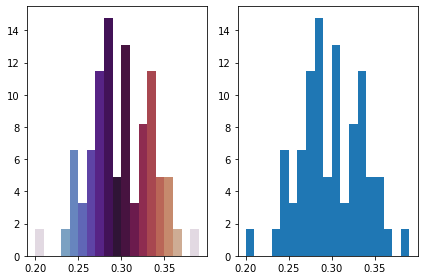

In [170]:
fig, axs = plt.subplots(1, 2, tight_layout=True)

vmin=0.2
vmax=0.4
bins = np.arange(vmin,vmax,0.01)
#colors.Colormap('twilight')
cm = plt.cm.get_cmap('twilight')
# N is the count in each bin, bins is the lower-limit of the bin
n, bins, patches = axs[0].hist(Clap_Feats.iloc[80,:].values,bins,density=True, histtype='bar')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# We'll color code by height, but you could use any scalar
fracs = bins / bins.max()

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))


# # we need to normalize the data to 0..1 for the full range of the colormap
# norm = colors.Normalize(fracs.min(), fracs.max())

# # Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
axs[1].hist(Clap_Feats.iloc[80,:].values,bins,density=True, histtype='bar')


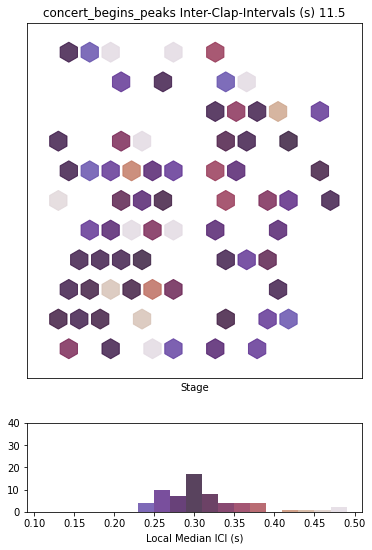

In [172]:
slice_i = 50
vmin=0.11
vmax=0.51
bins = np.arange(vmin,vmax,0.02)
colours = 'twilight'
cm = plt.cm.get_cmap(colours)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# We'll color code by height, but you could use any scalar
fracs = bins / bins.max()
col = bin_centers - min(bin_centers)
col /= max(col)

fig, ax = plt.subplots(2, 1, figsize = (6,9),gridspec_kw={'height_ratios': [4, 1]})

ax[0].scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[slice_i,:].values, cmap=colours, vmin=vmin, vmax=vmax, s=400, marker="h", alpha=0.8)
ax[0].set_xlim([-8,8])
ax[0].set_ylim([0,12])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('Stage')
ax[0].set_title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))

# N is the count in each bin, bins is the lower-limit of the bin
n, bins, patches = ax[1].hist(Clap_Feats.iloc[slice_i,:].values,bins,alpha=0.8)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
ax[1].set_xlabel('Local Median ICI (s)')
ax[1].set_ylim([0,40])
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

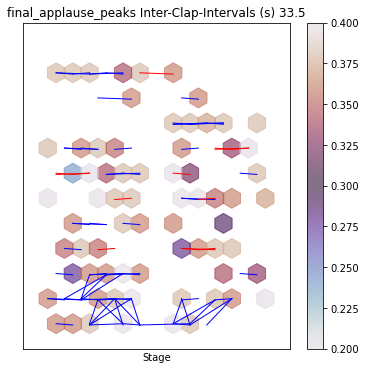

In [143]:
i = 160
plt.figure(figsize=[6,6])
plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values, cmap='twilight', vmin=0.2, vmax=0.4, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,13])
plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[i,:].name,2)))
cbar = plt.colorbar()

# now add the relationships Friends
Friends = Near_Rels[Near_Rels['Relationship'].str.contains('Friend')]
Friends
for i,ship in Friends.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:] 
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.05,P2['X']]),'b',linewidth = 1)

Family = Near_Rels[Near_Rels['Relationship'].str.contains('Family')]
Family
for i,ship in Family.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:]
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.05,P2['X']]),'r',linewidth = 1)


# cbar.solids.set_edgecolor("face")
# plt.draw()
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

In [144]:
# generate gif with this 
filenames = []
for i in range(len(Clap_Feats)):
    # plot the line chart
    plt.figure(figsize=[6,6])
    plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values,  cmap='twilight', vmin=0.2, vmax=0.5, s=400, marker="h", alpha=0.6)
    plt.xlim([-8,8])
    plt.ylim([0,13])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Stage')
    plt.title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[i,:].name,2)))
    cbar = plt.colorbar()
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
# extend the last image before looping
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
# build gif
gif_path = './plots/Clapping_'+clapname[:-4]+'_ICI_5hz.gif'
with imageio.get_writer(gif_path, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [ ]:
import moviepy.editor as mp

clip = mp.VideoFileClip("mygif.gif")
clip.write_videofile("myvideo.mp4")

In [173]:
# generate gif with this 
filenames = []
vmin=0.11
vmax=0.51
bins = np.arange(vmin,vmax,0.02)
colours = 'twilight'
cm = plt.cm.get_cmap(colours)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# We'll color code by height, but you could use any scalar
fracs = bins / bins.max()
col = bin_centers - min(bin_centers)
col /= max(col)

for slice_i in range(len(Clap_Feats)):
    fig, ax = plt.subplots(2, 1, figsize = (6,9),gridspec_kw={'height_ratios': [4, 1]})

    ax[0].scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[slice_i,:].values, cmap=colours, vmin=vmin, vmax=vmax, s=400, marker="h", alpha=0.6)
    ax[0].set_xlim([-8,8])
    ax[0].set_ylim([0,12])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel('Stage')
    ax[0].set_title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))

    # N is the count in each bin, bins is the lower-limit of the bin
    n, bins, patches = ax[1].hist(Clap_Feats.iloc[slice_i,:].values,bins,alpha=0.6)
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    ax[1].set_xlabel('Local Median ICI (s)')
    ax[1].set_ylim([0,40])

    # create file name and append it to a list
    filename = f'{slice_i}.png'
    filenames.append(filename)
    
    
    # save frame
    plt.savefig(filename)
    plt.close()
# extend the last image before looping
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
# build gif
gif_path = './plots/Clapping_'+clapname[:-4]+'_ICI_5hz_hist.gif'
with imageio.get_writer(gif_path, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [106]:
pwd

'C:\\Users\\finnu\\dev\\Clapping_Coordination'

# Spacial and Social factors for clapping rates?

- Look at pairwise local ICI medians for all relationships (spatial, social)

In [80]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Part_Codes = Clap_Feats.columns
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
Sub_Rels.loc[Sub_Rels['Distance'] == -2.0,'Distance'] = 2.0
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ023,2.0,0,Stranger
2,ADQ001,ADQ024,2.0,0,Stranger
3,ADQ001,ADQ031,2.0,0,Stranger
4,ADQ001,ADQ035,2.0,0,Stranger
...,...,...,...,...,...
375,AEQ080,AEQ081,3.0,0,Stranger
376,AEQ080,AEQ089,1.0,1,Family_ParentChild
377,AEQ081,AEQ082,1.0,1,Family_Partner
378,AEQ082,AEQ087,3.0,0,Stranger


Do participants clap like their neighbours during independent clapping? how about during synchronised clapping? do they clap as long as their neighbours/friends?

##  Clapping duration and intensity
By correlating clapping features over the full intervals, we can capture pairwise similarity between neighbours and friends in when they clap, when they clap fastest or slowest and when they are still. This is not evaluating if they clapped in synch.

<AxesSubplot:>

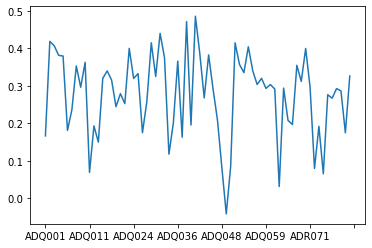

In [47]:
A = Clap_Feats.corr(method = 'spearman')
A.median().plot()

In [48]:
# build a data frame with pairwise spearman correlations as a dependent variable
Sub_Rels['Seg_Corr'] = 0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Corr'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [50]:
pg.anova(dv="Seg_Corr",between = ["Distance","Relationship"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.000210,2.0,0.000105,0.002711,9.972930e-01,0.000015
1,Relationship,26.890052,5.0,5.378010,139.111313,1.917307e-82,0.654607
2,Distance * Relationship,0.559948,10.0,0.055995,1.448399,1.572207e-01,0.037967
3,Residual,14.188133,367.0,0.038660,NaN,NaN,NaN


In [49]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.094456,2.0,0.047228,1.194645,0.303964,0.006348
1,Familiarity,0.016884,1.0,0.016884,0.427074,0.513830,0.001141
2,Distance * Familiarity,0.043193,2.0,0.021597,0.546296,0.579552,0.002913
3,Residual,14.785371,374.0,0.039533,NaN,NaN,NaN


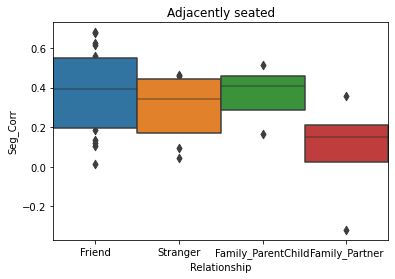

         Source  ddof1  ddof2         F     p-unc       np2
0  Relationship      3     31  2.292741  0.097496  0.181588


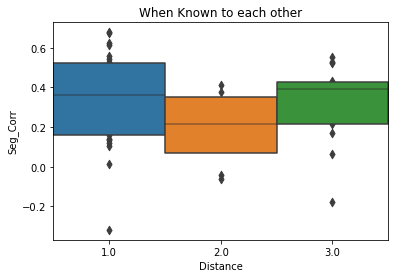

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2     46  1.005449  0.373778  0.041884


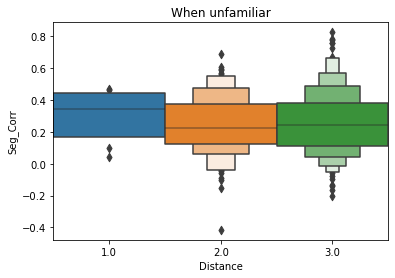

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    328  0.537396  0.584781  0.003266


In [51]:
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.boxenplot(x = "Relationship",y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Relationship", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels["Familiarity"] == 1]
sns.boxenplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When Known to each other')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
sns.boxenplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

There is not a strong relationships between the shape of peoples clapping rates during this final applayse and whether they were sitting side by side or familiar with each other. The suggested deviation of couples contrasting strongly may be due to some kind of outlier effect. 

## Clapping Rates during independent applause
look at intervals when everyone was clapping before synchronisation [10,20]s

<AxesSubplot:>

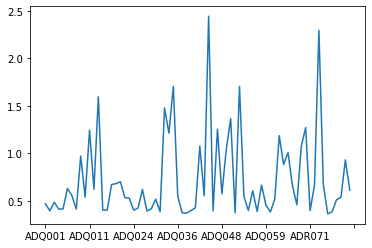

In [52]:
# Euclidian distance metric
sub_Claps = Clap_Feats.loc[10:20] # 10 seconds during which participants clapped indepnendently
A = pd.DataFrame(squareform(pdist(sub_Claps.T)), columns = sub_Claps.columns, index = sub_Claps.columns)
A.median().plot()

In [53]:
Sub_Rels['Seg_Dist'] = 0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Dist'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [54]:
pg.anova(dv="Seg_Dist",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.802100,2.0,0.401050,0.967224,0.381086,0.005146
1,Familiarity,0.098245,1.0,0.098245,0.236940,0.626710,0.000633
2,Distance * Familiarity,0.239196,2.0,0.119598,0.288438,0.749600,0.001540
3,Residual,155.075475,374.0,0.414640,NaN,NaN,NaN


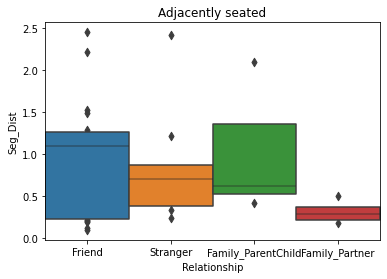

         Source  ddof1  ddof2         F   p-unc       np2
0  Relationship      3     31  0.989414  0.4106  0.087383


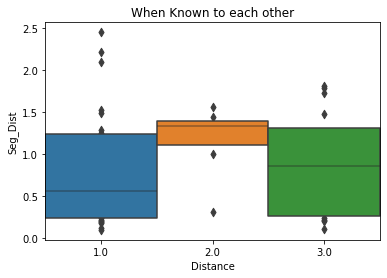

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2     46  0.736932  0.484144  0.031046


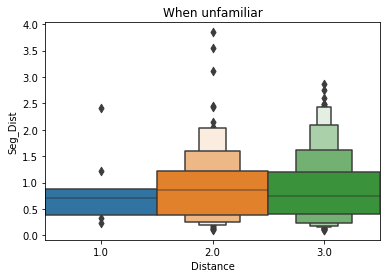

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    328  0.523373  0.593012  0.003181


In [57]:
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.boxenplot(x = "Relationship",y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Relationship", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels["Familiarity"] == 1]
sns.boxenplot(x = 'Distance',y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('When Known to each other')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
sns.boxenplot(x = 'Distance',y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)

## Clapping Rates during transition to Sychronised applause
look at intervals when everyone was clapping before synchronisation [30,40]s

<AxesSubplot:>

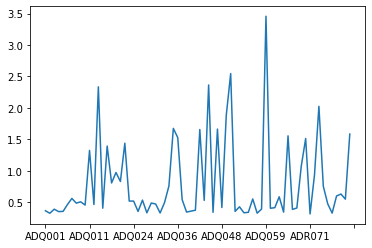

In [81]:
# Euclidian distance metric
sub_Claps = Clap_Feats.loc[20:30] # 10 seconds during which participants clapped indepnendently
A = pd.DataFrame(squareform(pdist(sub_Claps.T)), columns = sub_Claps.columns, index = sub_Claps.columns)
A.median().plot()

In [82]:
Sub_Rels['Seg_Dist'] = 0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Dist'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [83]:
pg.anova(dv="Seg_Dist",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,1.181529,2.0,0.590765,0.758787,0.468954,0.004041
1,Familiarity,0.679256,1.0,0.679256,0.872446,0.350882,0.002327
2,Distance * Familiarity,0.814331,2.0,0.407166,0.522970,0.593191,0.002789
3,Residual,291.183141,374.0,0.778565,NaN,NaN,NaN


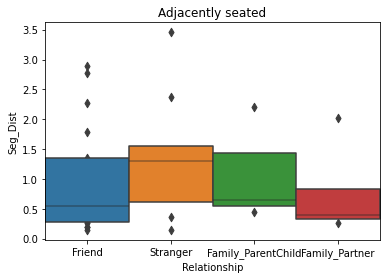

         Source  ddof1  ddof2         F     p-unc       np2
0  Relationship      3     31  0.542729  0.656668  0.049901


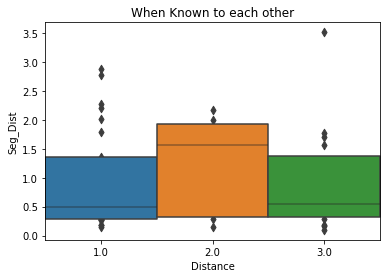

     Source  ddof1  ddof2         F    p-unc       np2
0  Distance      2     46  0.314862  0.73145  0.013505


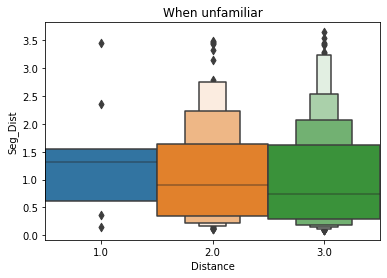

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    328  0.969263  0.380446  0.005875


In [84]:
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.boxenplot(x = "Relationship",y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Relationship", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels["Familiarity"] == 1]
sns.boxenplot(x = 'Distance',y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('When Known to each other')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
sns.boxenplot(x = 'Distance',y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)

# looking at larger distances between pairs

In [62]:
# collect all pairwise distances, modefied from nearby
nearby = []
for i,a in partDets.iterrows():
    A = ((partDets.loc[i+1:,'X'] - a['X']).pow(2)+(partDets.loc[i+1:,'Y'] - a['Y']).pow(2)).pow(0.5)
    if len(A)>0:
        neighs = partDets.loc[A.index].index
        Dist = A
        for j in range(len(neighs)):
            c = neighs[j]
            nearby.append([partDets.loc[i].Participant_Code,partDets.loc[c].Participant_Code,Dist.iloc[j]])
len(nearby)    

4095

In [63]:
# file not currently public
rel_folder = general_loc + 'Concert_MusicLab/Participant_details/'
Rels = pd.read_csv(rel_folder + 'Pairwise_Relationship_Hall.csv') 
print(len(Rels))

86


In [64]:
Near_Rels = pd.DataFrame(columns=["Participant_Code_1","Participant_Code_2","Distance","Familiarity","Relationship"])

for i in range(len(nearby)):
    ns = nearby[i]
    Near_Rels.loc[i,"Participant_Code_1"] = ns[0]
    Near_Rels.loc[i,"Participant_Code_2"] = ns[1]


    P1 = partDets.loc[partDets['Participant_Code'] == ns[0],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ns[1],:]
    
#     if P2['X'].values-P1['X'].values<0:
#         distC = -1 # P1 is behind P2
#     else:
#         distC = 1
    
    Near_Rels.loc[i,"Distance"] = np.round(ns[2]) # simplify stratification
#     if ns[2]>=2: # around
#         Near_Rels.loc[i,"Distance"] = 3.0
#     else:
#         if ns[2]>1: # close
#             Near_Rels.loc[i,"Distance"] =  distC * 2.0
#         else: # adjacent
#             Near_Rels.loc[i,"Distance"] = 1.0
    # check if 
    A = Rels.loc[Rels['P1']==P1['Temp_Codes'].values[0]]
    if len(A)<1: 
        A = Rels.loc[Rels['P2']==P1['Temp_Codes'].values[0]]
        R = A.loc[A['P1']==P2['Temp_Codes'].values[0]]
    else:
        R = A.loc[A['P2']==P2['Temp_Codes'].values[0]]
        if len(R)<1: # check the alternate order, just in case
            A = Rels.loc[Rels['P2']==P1['Temp_Codes'].values[0]]
            R = A.loc[A['P1']==P2['Temp_Codes'].values[0]]

    if len(R)>0: # these two knew each other
        Near_Rels.loc[i,"Familiarity"] = 1 
        Near_Rels.loc[i,"Relationship"] = R.Relationship.values[0]
    else:
        Near_Rels.loc[i,"Familiarity"] = 0 
        Near_Rels.loc[i,"Relationship"] = 'Stranger'

Near_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ002,6.0,0,Stranger
1,ADQ001,ADQ003,6.0,0,Stranger
2,ADQ001,ADQ004,5.0,0,Stranger
3,ADQ001,ADQ005,6.0,0,Stranger
4,ADQ001,ADQ006,2.0,0,Stranger
...,...,...,...,...,...
4090,AEQ088,AER090,10.0,0,Stranger
4091,AEQ088,AEU091,12.0,0,Stranger
4092,AEQ089,AER090,10.0,0,Stranger
4093,AEQ089,AEU091,9.0,0,Stranger


In [65]:
# reduce to list of relationships included in the dataset available here
Part_Codes = Clap_Feats.columns
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
len(Sub_Rels)

2415

<AxesSubplot:>

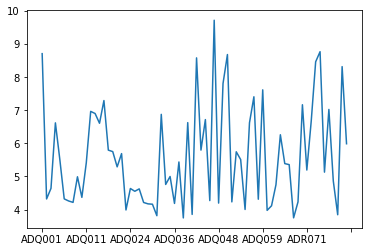

In [66]:
# Euclidian distance metric
A = pd.DataFrame(squareform(pdist(Clap_Feats.T)), columns = Clap_Feats.columns, index = Clap_Feats.columns)
A.median().plot()

In [67]:
Sub_Rels['Seg_Dist'] = 0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Dist'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [68]:
pg.anova(dv="Seg_Dist",between = ["Distance","Familiarity"], data=Sub_Rels)

C:\Users\finnu\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 4
  warnings.warn('covariance of constraints does not have full '


,Source,SS,DF,MS,F,p-unc,np2
0,Distance,4085.153608,14.0,291.796686,54.659415,3.726452e-44,0.242068
1,Familiarity,740.309395,1.0,740.309395,138.674906,3.684409e-31,0.054711
2,Distance * Familiarity,500.281014,14.0,35.734358,6.693767,1.483508e-13,0.037640
3,Residual,12790.932089,2396.0,5.338452,NaN,NaN,NaN


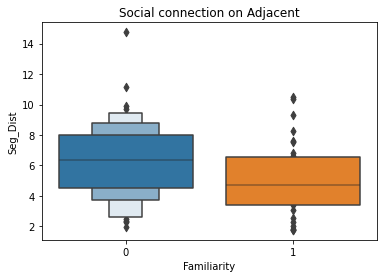

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   2413  2.280599  0.131132  0.000944


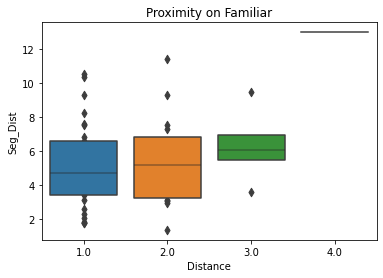

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      3     46  3.219506  0.031208  0.173532


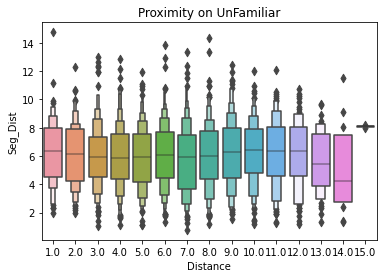

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance     14   2350  1.221333  0.251929  0.007223


In [69]:
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
#sns.set_theme(style="whitegrid")
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.boxenplot(x = 'Familiarity',y = 'Seg_Dist', data = Sub_Sub_Rels)
plt.title('Social connection on Adjacent')
# plt.savefig('plots/PairCorr_allEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Familiarity", data=Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 1.0]
sns.boxenplot(x = 'Distance',y = 'Seg_Dist', data = Sub_Sub_Rels)
plt.title('Proximity on Familiar')
# plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0.0]
sns.boxenplot(x = 'Distance',y = 'Seg_Dist', data = Sub_Sub_Rels)
plt.title('Proximity on UnFamiliar')
# plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)


<AxesSubplot:>

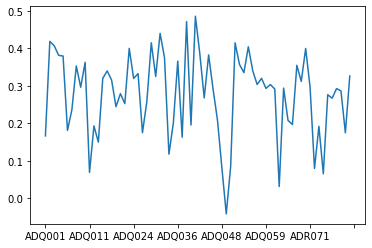

In [71]:
A = Clap_Feats.corr(method = 'spearman')
A.median().plot()

In [72]:
# build a data frame with pairwise spearman correlations as a dependent variable
Sub_Rels['Seg_Corr'] = 0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Corr'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [74]:
Sub_Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Dist,Seg_Corr
0,ADQ001,ADQ002,6.0,0,Stranger,8.327298,0.147928
1,ADQ001,ADQ003,6.0,0,Stranger,8.957823,0.252337
2,ADQ001,ADQ004,5.0,0,Stranger,9.589442,0.363053
3,ADQ001,ADQ005,6.0,0,Stranger,8.960915,0.394702
4,ADQ001,ADQ006,2.0,0,Stranger,7.961313,0.153698
...,...,...,...,...,...,...,...
2410,AEQ087,AEQ089,8.0,0,Stranger,7.845801,0.337797
2411,AEQ087,AER090,2.0,0,Stranger,5.566965,0.116322
2412,AEQ088,AEQ089,6.0,0,Stranger,7.573797,0.067183
2413,AEQ088,AER090,10.0,0,Stranger,4.845606,0.545691
